# Loop closure

### Boilerplate

In [3]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders
dig114


### Original approach for design and filtering docked helix binders
4) loops as before, just make sure to connect the right termini, and always carry the helix along  
I'll scale up the approach and collect additional metadata using `PyRosetta.distributed`  

I will try the following hierarchy of closure methods: 
1. close using identical length loop and no adjustment with connect chains mover (CCM) at 1.0 RMS (total length and SS match)
2. constrained remodel with `BluePrintBDR`, forcing SS agreement with parent but allowing any `ABEGO` (total length and SS match)  
These methods seemed to get around 75% closure for free hinges

Things that aren't at the moment worthwhile:
1. close using identical length loop and +/-2 res adjustment on each side with CCM at ?? RMS (total length match, potential SS mismatch)  
This one has issues with the adjustments resulting in unexpected lengths of the finished design 
2. Dmitri Zorine's brand new enumerative method  
Would like to try this at some point in the future though

### Make functions for looping and labeling to assist downstream penultimate design step

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init


@requires_init
def loop_match(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Match loop length, total length and DSSP with parent. Strictest method of closure.
    """
    import bz2
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    def append_b_to_a(pose_a: Pose, pose_b: Pose, end_a: int, start_b: int) -> Pose:
        """
        Make a new pose, containing pose_a up to end_a, then pose_b starting from start_b
        Assumes pose_a has only one chain.
        """
        import pyrosetta
        from pyrosetta.rosetta.core.pose import Pose

        newpose = Pose()
        for i in range(1, end_a + 1):
            newpose.append_residue_by_bond(pose_a.residue(i))
        newpose.append_residue_by_jump(
            pose_b.residue(start_b), newpose.chain_end(1), "CA", "CA", 1
        )
        for i in range(start_b + 1, len(pose_b.residues) + 1):
            newpose.append_residue_by_bond(pose_b.residue(i))
        return newpose

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_pose_in = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        raise RuntimeError("Need to supply an input")
    # get parent from packed_pose_in, get loop length from parent length - packed_pose_in length
    parent_length = int(scores["parent_length"])
    length = int(parent_length - packed_pose_in.pose.chain_end(2))
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>          
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <ConnectChainsMover name="closer" 
                chain_connections="[A+B]" 
                loopLengthRange="{length},{length}" 
                resAdjustmentRangeSide1="0,0" 
                resAdjustmentRangeSide2="0,0" 
                RMSthreshold="1.0"/>
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <PROTOCOLS>
            <Add mover_name="closer"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(
        length=length
    )
    closer = SingleoutputRosettaScriptsTask(xml)
    try:
        maybe_closed_ppose = closer(packed_pose_in.pose.clone())
        # hacky rechain
        maybe_closed_pose = append_b_to_a(
            pose_a=maybe_closed_ppose.pose.clone(),
            pose_b=packed_pose_in.pose.clone(),
            end_a=packed_pose_in.pose.chain_end(2),
            start_b=packed_pose_in.pose.chain_begin(3),
        )
        closure_type = "loop_match"
    except RuntimeError:
        maybe_closed_pose = io.to_pose(packed_pose_in.pose.clone())
        closure_type = "not_closed"
    pyrosetta.rosetta.core.pose.setPoseExtraScore(
        maybe_closed_pose, "closure_type", closure_type
    )
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(
            maybe_closed_pose, key, str(value)
        )
    final_ppose = io.to_packed(maybe_closed_pose)
    return final_ppose


def strict_remodel(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    DSSP and SS agnostic in principle but in practice more or less matches.
    """
    import os
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.packed_pose.core import PackedPose
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )
    from pyrosetta.rosetta.core.select import get_residues_from_subset
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects

    def phi_psi_omega_to_abego(phi: float, psi: float, omega: float) -> str:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        if psi == None or phi == None:
            return "X"
        if omega == None:
            omega = 180

        if abs(omega) < 90:
            return "O"
        elif phi > 0:
            if -100.0 <= psi < 100:
                return "G"
            else:
                return "E"
        else:
            if -75.0 <= psi < 50:
                return "A"
            else:
                return "B"
        return "X"

    def abego_string(phi_psi_omega: list) -> str:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        out = ""
        for x in phi_psi_omega:
            out += phi_psi_omega_to_abego(x[0], x[1], x[2])
        return out

    def get_torsions(pose: Pose) -> list:
        """
        From Buwei
        https://wiki.ipd.uw.edu/protocols/dry_lab/rosetta/scaffold_generation_with_piecewise_blueprint_builder
        """
        torsions = []
        for i in range(1, pose.total_residue() + 1):
            phi = pose.phi(i)
            psi = pose.psi(i)
            omega = pose.omega(i)
            if i == 1:
                phi = None
            if i == pose.total_residue():
                psi = None
                omega = None
            torsions.append((phi, psi, omega))
        return torsions

    def strict_remodel_helper(packed_pose_in: PackedPose, loop_length: int) -> str:
        import binascii, os
        import pyrosetta
        from pyrosetta.rosetta.core.pose import Pose

        pose = packed_pose_in.pose.clone()
        tors = get_torsions(pose)
        abego_str = abego_string(tors)
        dssp = pyrosetta.rosetta.protocols.simple_filters.dssp(pose)
        # name blueprint a random 32 long hex string
        filename = str(binascii.b2a_hex(os.urandom(16)).decode("utf-8")) + ".bp"
        # write a temporary blueprint file
        with open(filename, "w+") as f:
            end1, begin2 = (
                packed_pose_in.pose.chain_end(1),
                packed_pose_in.pose.chain_begin(2),
            )
            end3 = packed_pose_in.pose.chain_end(3)
            for i in range(1, end1 + 1):
                if i == end1:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + "X",
                        "R",
                        file=f,
                    )
                else:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + abego_str[i - 1],
                        ".",
                        file=f,
                    )
            for i in range(loop_length):
                print(
                    "0", "V", "LX", "R", file=f
                )  # DX is bad, causes rare error sometimes
            for i in range(begin2, end3 + 1):
                if i == begin2:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + "X",
                        "R",
                        file=f,
                    )
                else:
                    print(
                        str(i),
                        packed_pose_in.pose.residue(i).name1(),
                        dssp[i - 1] + abego_str[i - 1],
                        ".",
                        file=f,
                    )

        return filename

    def find_vv(seq):
        indices = []
        seq_minus_one = seq[:-1]
        for i, char in enumerate(seq_minus_one):
            if (char == seq[i + 1]) and (char == "V"):
                indices.append(i + 1)
            else:
                pass
        # rosetta sequence indexes begin at 1
        true_indices = [str(x + 1) for x in indices]
        return true_indices

    def append_b_to_a(pose_a: Pose, pose_b: Pose, end_a: int, start_b: int) -> Pose:
        """
        Make a new pose, containing pose_a up to end_a, then pose_b starting from start_b
        Assumes pose_a has only one chain.
        """
        import pyrosetta
        from pyrosetta.rosetta.core.pose import Pose

        newpose = Pose()
        for i in range(1, end_a + 1):
            newpose.append_residue_by_bond(pose_a.residue(i))
        newpose.append_residue_by_jump(
            pose_b.residue(start_b), newpose.chain_end(1), "CA", "CA", 1
        )
        for i in range(start_b + 1, len(pose_b.residues) + 1):
            newpose.append_residue_by_bond(pose_b.residue(i))
        return newpose

    # ensure pose still needs to be closed, skip to scoring and labeling if it has
    if packed_pose_in.pose.num_chains() == 2:
        maybe_closed_pose = packed_pose_in.pose.clone()
    else:
        scores = packed_pose_in.pose.scores
        # get parent from packed_pose_in, get loop length from parent length - packed_pose_in length
        parent_length = int(scores["parent_length"])
        length = int(parent_length - packed_pose_in.pose.chain_end(2))
        bp = strict_remodel_helper(packed_pose_in, length)
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
                <ScoreFunction name="sfxn1" weights="fldsgn_cen">
                    <Reweight scoretype="hbond_sr_bb" weight="1.0" />
                    <Reweight scoretype="hbond_lr_bb" weight="1.0" />
                    <Reweight scoretype="atom_pair_constraint" weight="1.0" />
                    <Reweight scoretype="angle_constraint" weight="1.0" />
                    <Reweight scoretype="dihedral_constraint" weight="1.0" />
                </ScoreFunction>
            </SCOREFXNS>
            <RESIDUE_SELECTORS>          
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
            </TASKOPERATIONS>
            <SIMPLE_METRICS>
            </SIMPLE_METRICS>
            <MOVERS>
                <BluePrintBDR name="bdr" 
                blueprint="{bp}" 
                use_abego_bias="0" 
                use_sequence_bias="0" 
                rmdl_attempts="20"
                scorefxn="sfxn1"/>
            </MOVERS>
            <FILTERS>
            </FILTERS>
            <PROTOCOLS>
                <Add mover_name="bdr"/>
            </PROTOCOLS>
        </ROSETTASCRIPTS>
        """.format(
            bp=bp
        )
        strict_remodel = SingleoutputRosettaScriptsTask(xml)
        maybe_closed_ppose = None
        for i in range(10):
            print(f"attempt: {i}")
            if maybe_closed_ppose is not None:  # check if it worked
                break  # stop retrying if it did
            else:  # try again if it didn't. returns None if fail
                maybe_closed_ppose = strict_remodel(packed_pose_in.pose.clone())
        os.remove(bp)  # cleanup tree
        if maybe_closed_ppose is not None:
            closure_type = "strict_remodel"
            # hacky rechain
            maybe_closed_pose = append_b_to_a(
                pose_a=maybe_closed_ppose.pose.clone(),
                pose_b=packed_pose_in.pose.clone(),
                end_a=packed_pose_in.pose.chain_end(2),
                start_b=packed_pose_in.pose.chain_begin(3),
            )
            for key, value in scores.items():
                pyrosetta.rosetta.core.pose.setPoseExtraScore(
                    maybe_closed_pose, key, str(value)
                )
            # update closure_type
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                maybe_closed_pose, "closure_type", closure_type
            )

        else:  # return the original input if BlueprintBDR still didn't close

            maybe_closed_pose = packed_pose_in.pose.clone()

    # switch scores to new score dict
    scores = maybe_closed_pose.scores
    # ensure pose has been closed, if not don't label new loop
    if maybe_closed_pose.num_chains() != 2:
        new_loop_str = "0,0"
        labeled_pose = maybe_closed_pose.clone()
    else:
        seq = str(maybe_closed_pose.sequence())
        vv_indices = ",".join(find_vv(seq))
        pre_break_helix = int(scores["pre_break_helix"])
        # get helix indices for the pre and post break helices. assumes middle loop of chA is the new one
        lower = pre_break_helix
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
            </SCOREFXNS>
            <RESIDUE_SELECTORS>
                <SSElement name="middle" selection="{pre},H,S" to_selection="-{post},H,E" chain="A" reassign_short_terminal_loop="2" />       
                <Index name="polyval_all" resnums="{vv_indices}" />
                <And name="polyval" selectors="middle,polyval_all" />
                <PrimarySequenceNeighborhood name="entire_val" selector="polyval" lower="5" upper="5" />
                <SecondaryStructure name="loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
                <And name="new_loop_center" selectors="entire_val,loop" />
                <PrimarySequenceNeighborhood name="entire_new_loop_broad" selector="new_loop_center" lower="5" upper="5" />
                <ResidueName name="isval" residue_name3="VAL" />
                <And name="entire_new_loop" selectors="entire_new_loop_broad,isval" />
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
            </TASKOPERATIONS>
            <SIMPLE_METRICS>
            </SIMPLE_METRICS>
            <MOVERS>
                <SwitchChainOrder name="rechain" chain_order="12"/>
            </MOVERS>
            <FILTERS>
            </FILTERS>
            <PROTOCOLS>
                <Add mover="rechain" />
            </PROTOCOLS>
        </ROSETTASCRIPTS>
        """.format(
            pre=pre_break_helix, post=pre_break_helix, vv_indices=vv_indices
        )
        labeled = SingleoutputRosettaScriptsTask(xml)
        xml_obj = XmlObjects.create_from_string(xml)
        entire_new_loop_sel = xml_obj.get_residue_selector("entire_new_loop")
        labeled_ppose = labeled(maybe_closed_pose.clone())
        labeled_pose = io.to_pose(labeled_ppose)
        new_loop_resis = list(
            get_residues_from_subset(entire_new_loop_sel.apply(labeled_pose))
        )
        new_loop_str = ",".join(str(resi) for resi in new_loop_resis)

    pyrosetta.rosetta.core.pose.setPoseExtraScore(
        labeled_pose, "new_loop_resis", new_loop_str
    )
    total_length = len(labeled_pose.residues)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(
        labeled_pose, "total_length", total_length
    )
    dssp = pyrosetta.rosetta.protocols.simple_filters.dssp(labeled_pose)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "dssp", dssp)
    tors = get_torsions(labeled_pose)
    abego_str = abego_string(tors)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, "abego_str", abego_str)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(labeled_pose, key, str(value))
    final_ppose = io.to_packed(labeled_pose.clone())

    return final_ppose

### Setup dask, set command line options, make tasks and submit to client
At some point I should try using `client.wait_for_workers(n_workers=1, timeout=None)`

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


def create_tasks(selected, options):
    with open(selected, "r") as f:
        for file in f:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = file.rstrip()
            yield tasks


logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "02_design_score/not_bad.list")
options = {
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
}

output_path = os.path.join(os.getcwd(), "03_enumerate_loops")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="8GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,  # TODO
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[loop_match, strict_remodel])

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig114
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.218:44603 --nthreads 1 --memory-limit 7.45GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.218:44603' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


### Look at scores
Hacky function to load JSON-like data

In [4]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "03_enumerate_loops")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,abego_str,bb_clash,closure_type,cmsa_AB,cmsa_AC,cmsa_BC,docked_helix,dslf_fa13,dssp,fa_atr,...,sc_int_AB,sc_int_AC,sc_int_BC,score_AB,score_AC,score_BC,score_per_res,shift,total_length,total_score
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/03_enumerate_loops/decoys/0000/2021.05.28.14.56.04.308744_e21fdb0c9f3947939746d055a977be25.pdb.bz2,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAABABA...,764.2959594726562,loop_match,334.8529357910156,323.266845703125,354.35223388671875,6,0.0,LHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHHHHHLLLH...,-1285.937745,...,0.7595151662826538,0.7535297274589539,0.7630791664123535,-308.35748291015625,-147.03692626953125,-164.6107635498047,-2.9257113933563232,-4,197.0,487.952011
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/03_enumerate_loops/decoys/0000/2021.05.28.14.56.04.308744_dcda8d8a047c47ac86f4e297b076e1b8.pdb.bz2,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,84.6981201171875,loop_match,387.8190612792969,477.1015625,325.6720886230469,3,0.0,LLHHHHHHHHHHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHH...,-1616.712410,...,0.7409623861312866,0.7455334663391113,0.7105339169502258,-346.9720153808594,-191.43528747558594,-176.47616577148438,-2.8010482788085938,3,247.0,6358.038772
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/03_enumerate_loops/decoys/0000/2021.05.28.14.56.04.308744_f28bc06b23b24e1d8fb820070fca846d.pdb.bz2,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAAA...,87.48668670654297,loop_match,388.5936584472656,312.7015686035156,391.46844482421875,5,0.0,LHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHHHHHHHHH...,-2115.748647,...,0.6870797872543335,0.7730302810668945,0.7818359136581421,-508.3931884765625,-281.3547058105469,-264.6188049316406,-2.7718827724456787,-1,319.0,2927.397465
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/03_enumerate_loops/decoys/0000/2021.05.28.14.56.04.308744_ecaec6f3c0db4ba3bb7706ae7e69e485.pdb.bz2,XBAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAA...,81.79435729980469,strict_remodel,525.454833984375,282.0914001464844,259.8425598144531,6,0.0,LLHHHHHHHHHHHHHHHHHHHHHHHHHHHLLHHHHHHHHHHHHHHH...,-1557.489440,...,0.7948428392410278,0.8382648229598999,0.7676059007644653,-377.542236328125,-187.04693603515625,-179.89637756347656,-2.84433650970459,6,243.0,4079.461776
/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/03_enumerate_loops/decoys/0000/2021.05.28.14.56.04.308744_1b6a5495bed34c0b9b9ad0c23598faff.pdb.bz2,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAABAB...,3571.5048828125,strict_remodel,356.9518737792969,326.8448791503906,300.3343811035156,6,0.0,LHHHHHHHHHHHHHHHHHHLLLLHHHHHHHHHHHHHHHHHHHHLLL...,-1251.421274,...,0.7545125484466553,0.7734614610671997,0.7496403455734253,-221.6053924560547,-106.59703826904297,-134.11380004882812,-2.405405044555664,-4,199.0,378.321838


In [5]:
len(scores_df)

2046

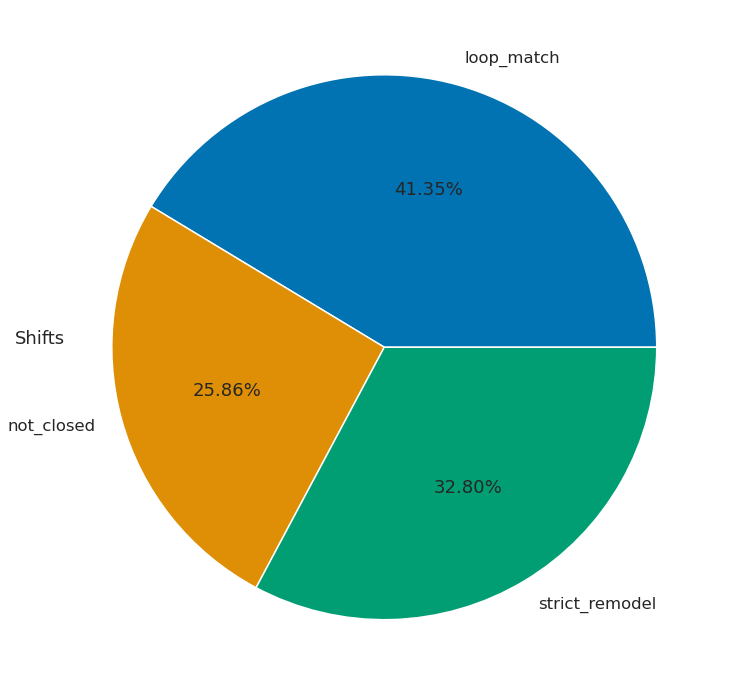

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
(
    fig,
    ax1,
) = plt.subplots(ncols=1, figsize=(20, 10), tight_layout=True)
scores_df.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
ax1.set_ylabel("Shifts", rotation=0)
plt.savefig("figs/03_closure_types.png")

### What metadata predicts looping failures?

In [10]:
scores_df.columns

Index(['abego_str', 'bb_clash', 'closure_type', 'cmsa_AB', 'cmsa_AC',
       'cmsa_BC', 'docked_helix', 'dslf_fa13', 'dssp', 'fa_atr', 'fa_dun_dev',
       'fa_dun_rot', 'fa_dun_semi', 'fa_elec', 'fa_intra_atr_xover4',
       'fa_intra_elec', 'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep',
       'fa_sol', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb',
       'hxl_tors', 'interface_buried_sasa', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'new_loop_resis', 'omega',
       'p_aa_pp', 'parent', 'parent_length', 'pivot_helix', 'pre_break_helix',
       'pro_close', 'rama_prepro', 'ref', 'sasa_AB', 'sasa_AC', 'sasa_BC',
       'sc', 'sc_int', 'sc_int_AB', 'sc_int_AC', 'sc_int_BC', 'score_AB',
       'score_AC', 'score_BC', 'score_per_res', 'shift', 'total_length',
       'total_score', 'scaffold'],
      dtype='object')

In [11]:
def parent2scaffold(row):
    parent = row["parent"]
    if "THR" in parent:
        scaffold = "THR"
    elif "TH_DHR" in parent:
        scaffold = "TH_DHR"
    elif "KH_" in parent:
        scaffold = "KH_DHR"
    elif "hDHR" in parent:
        scaffold = "hDHR"
    elif "DHR" in parent:
        scaffold = "DHR"
    else:
        raise RuntimeError
    return scaffold


scores_df["scaffold"] = scores_df.apply(parent2scaffold, axis=1)
scores_df.groupby(["scaffold"]).mean()

,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,fa_intra_sol_xover4,...,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,omega,p_aa_pp,pro_close,rama_prepro,ref,total_length,total_score
scaffold,,,,,,,,,,,,,,,,,,,,,
DHR,0.0,-1371.631579,209.184810,189.905525,238.206789,-449.909931,-80.942345,-42.583325,394.432388,58.141209,...,2.914408,21.219739,1535.916691,89.984468,-66.548049,17.162906,38.298656,-31.068097,208.682415,2334.064167
KH_DHR,0.0,-1307.895033,316.560529,167.206578,263.724273,-425.069165,-81.810713,-44.640155,1084.799966,59.154015,...,4.125667,29.031852,1469.564085,105.563235,-69.657684,0.448194,44.210417,-15.128439,206.375000,3232.137575
THR,0.0,-2371.132247,269.203696,310.327226,402.467857,-754.999597,-144.006265,-65.000414,521.678004,96.894125,...,7.130410,52.896056,2563.250438,102.499345,-108.682780,11.942502,110.763679,-45.946067,362.766440,2497.215739
TH_DHR,0.0,-1590.085501,217.523025,215.872965,263.487508,-523.664197,-92.285271,-56.243349,474.072039,63.716397,...,4.509240,32.102230,1763.457858,81.086969,-80.208488,18.700713,24.479680,19.549118,243.805627,2768.128963
hDHR,0.0,-1314.490549,213.212617,179.639745,232.125476,-427.177665,-79.202816,-46.484185,459.913220,58.340568,...,3.517491,25.859228,1471.912323,86.845724,-62.261938,17.534895,37.105451,-28.528609,205.958791,2561.837255


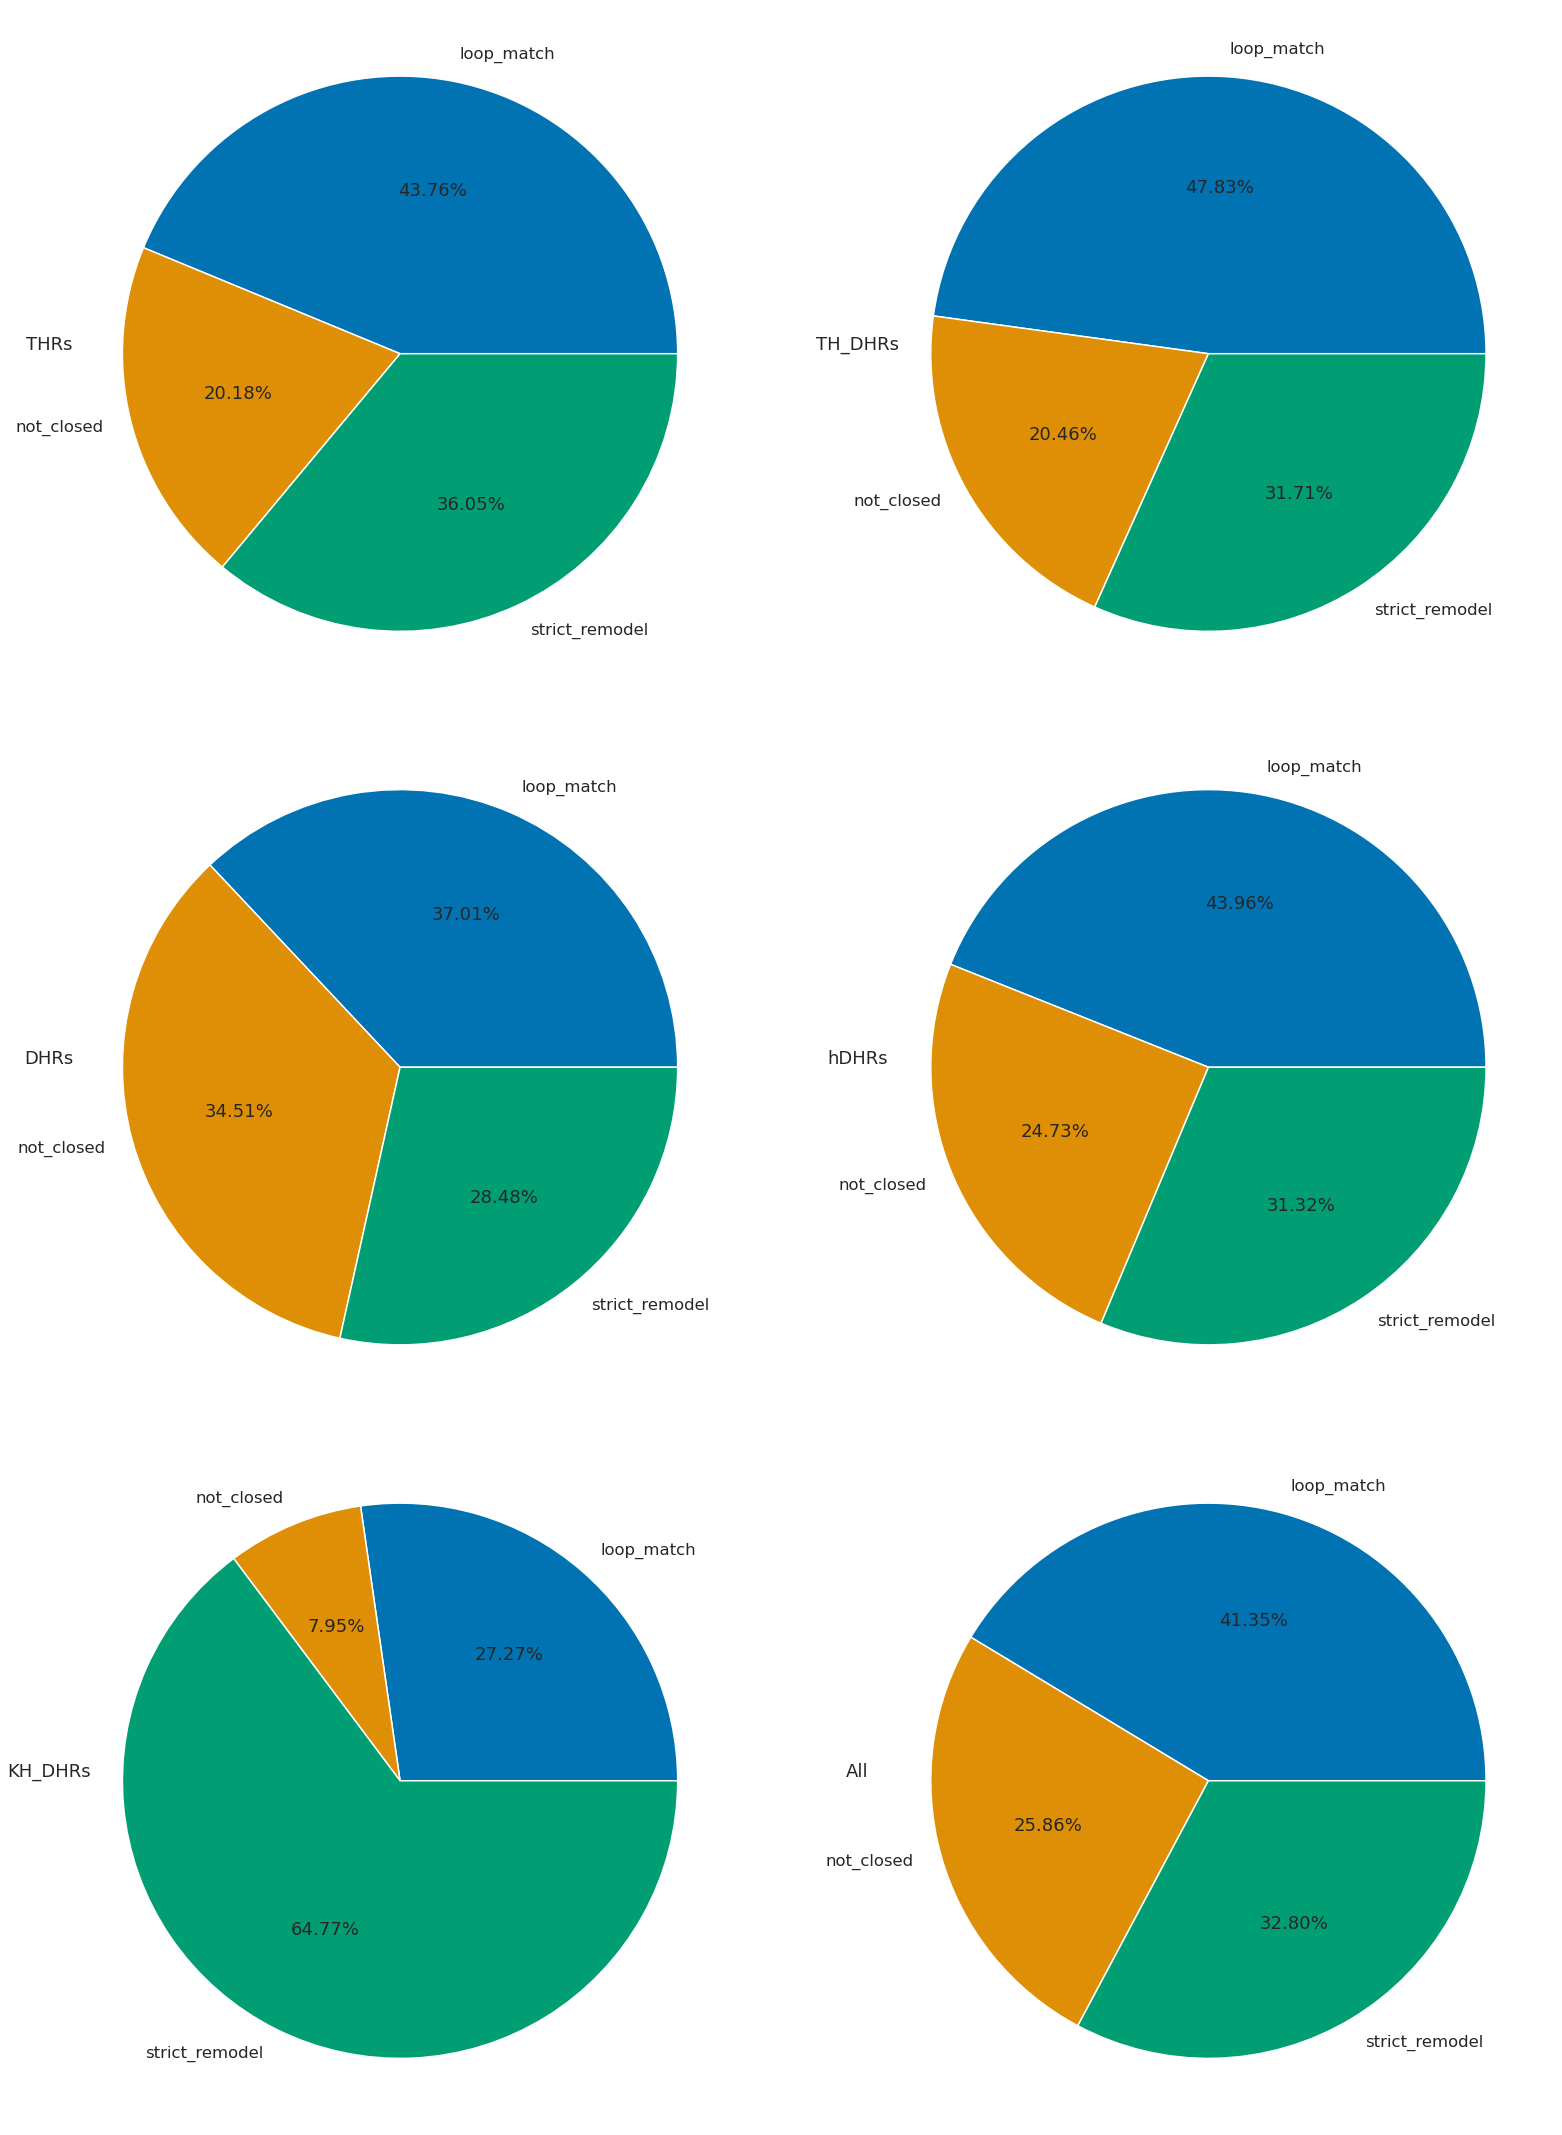

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    ncols=2, nrows=3, figsize=(30, 30), tight_layout=True
)
scores_df[scores_df["scaffold"] == "THR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax1
)
scores_df[scores_df["scaffold"] == "TH_DHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax2
)
scores_df[scores_df["scaffold"] == "DHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax3
)
scores_df[scores_df["scaffold"] == "hDHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax4
)
scores_df[scores_df["scaffold"] == "KH_DHR"].groupby("closure_type").size().plot(
    kind="pie", autopct="%1.2f%%", ax=ax5
)
scores_df.groupby("closure_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax6)
ax1.set_ylabel("THRs", rotation=0)
ax2.set_ylabel("TH_DHRs", rotation=0)
ax3.set_ylabel("DHRs", rotation=0)
ax4.set_ylabel("hDHRs", rotation=0)
ax5.set_ylabel("KH_DHRs", rotation=0)
ax6.set_ylabel("All", rotation=0)
plt.savefig("figs/03_looping_counts_by_scaffold.png")

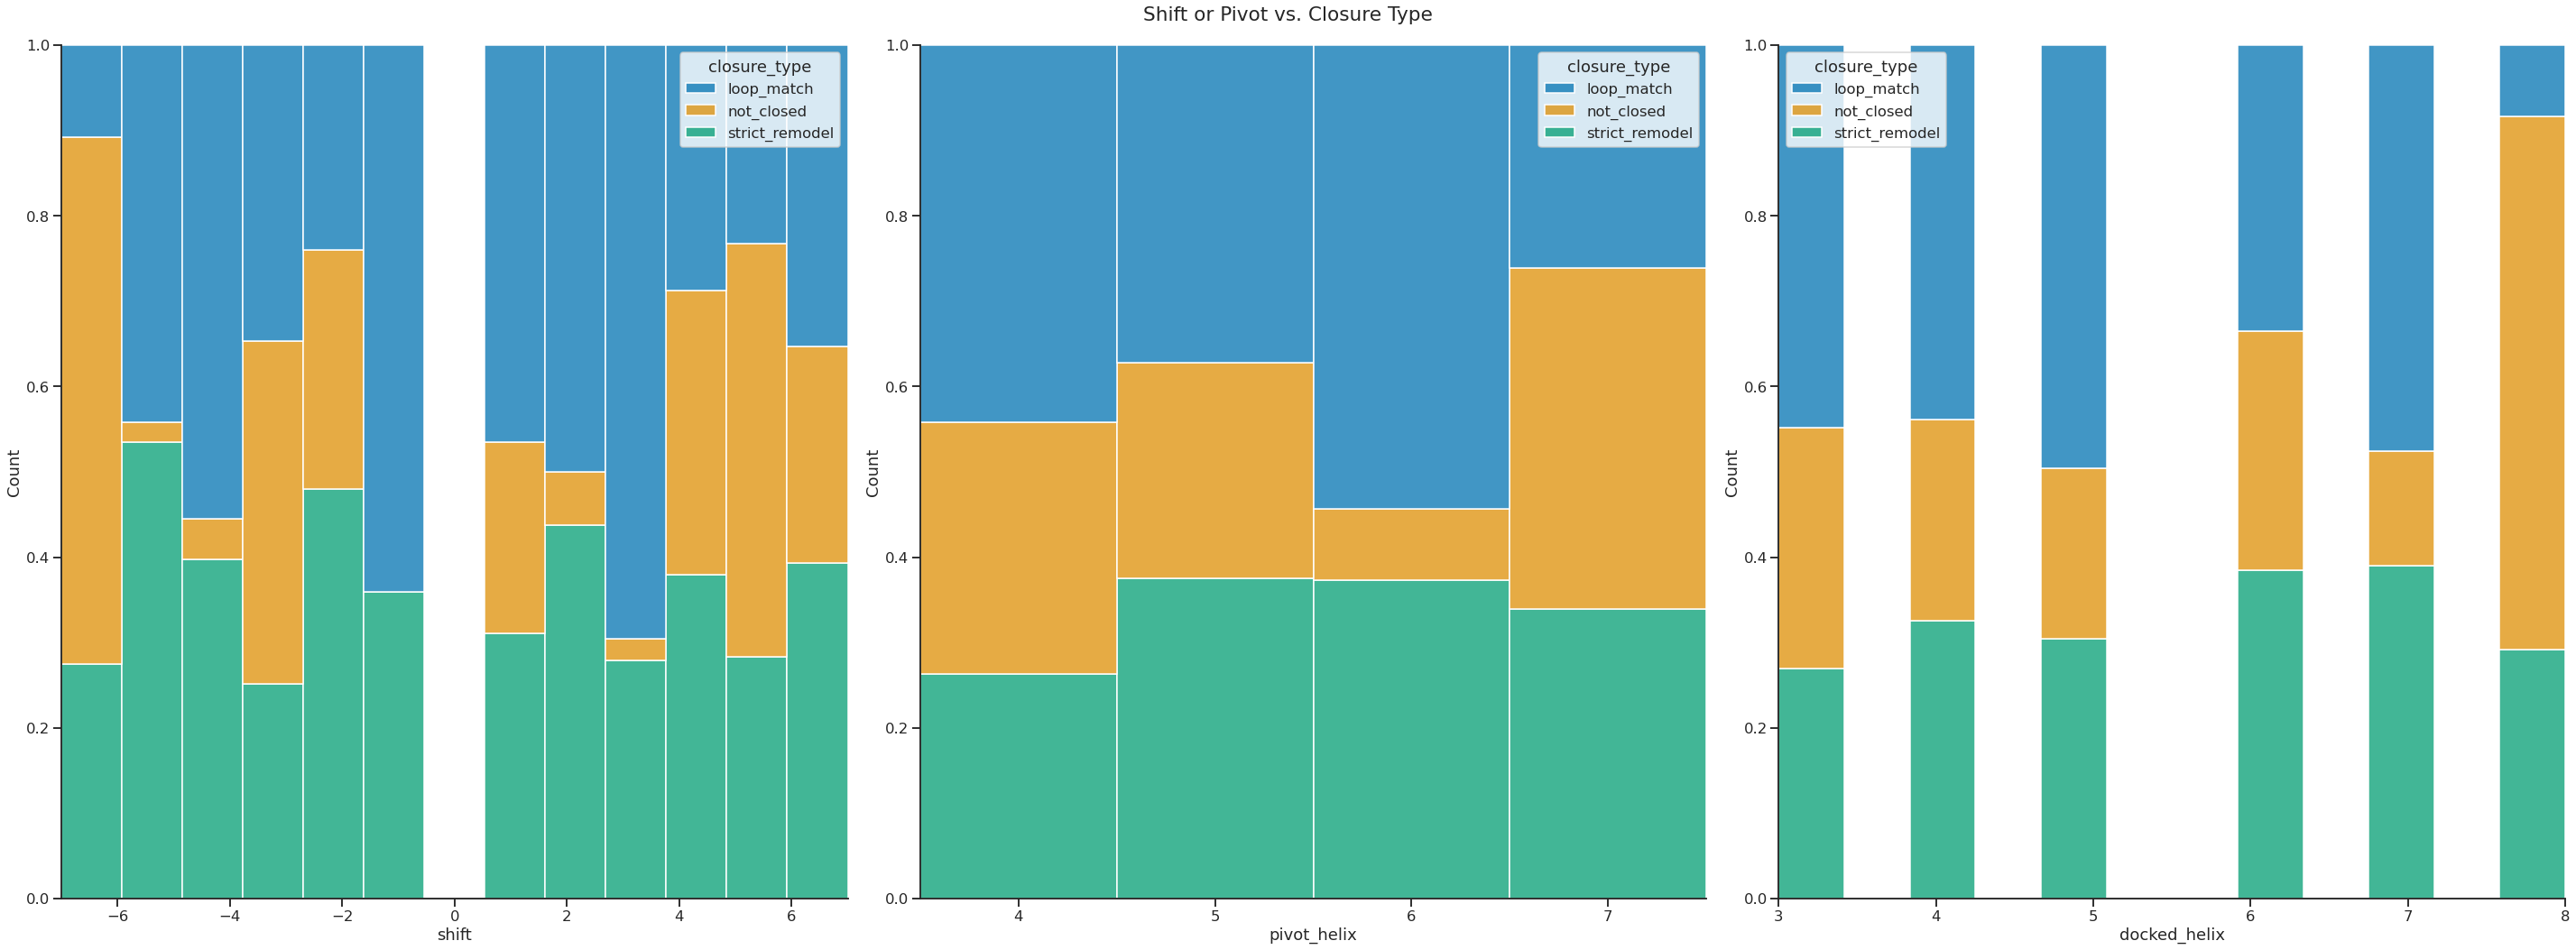

In [17]:
hue_order = ["loop_match", "not_closed", "strict_remodel"]  # for consistency with above

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(40, 15), tight_layout=True)

temp_df = scores_df.copy()
temp_df["shift"] = temp_df["shift"].astype(int)
temp_df["docked_helix"] = temp_df["docked_helix"].astype(int)


sns.histplot(
    x="shift",
    data=temp_df.sort_values(["shift"]),
    ax=ax1,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)

sns.histplot(
    x="pivot_helix",
    data=scores_df.sort_values(["pivot_helix"]),
    ax=ax2,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)

sns.histplot(
    x="docked_helix",
    data=temp_df.sort_values(["docked_helix"]),
    ax=ax3,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)


sns.despine()
plt.suptitle("Shift or Pivot vs. Closure Type")
plt.savefig("figs/03_shift_vs_pivot_groupby_closure.png")

### Interpretations:
Larger shifts can be harder to loop. Also, there are no 0 shifts because they were filtered out by `bb_clash`

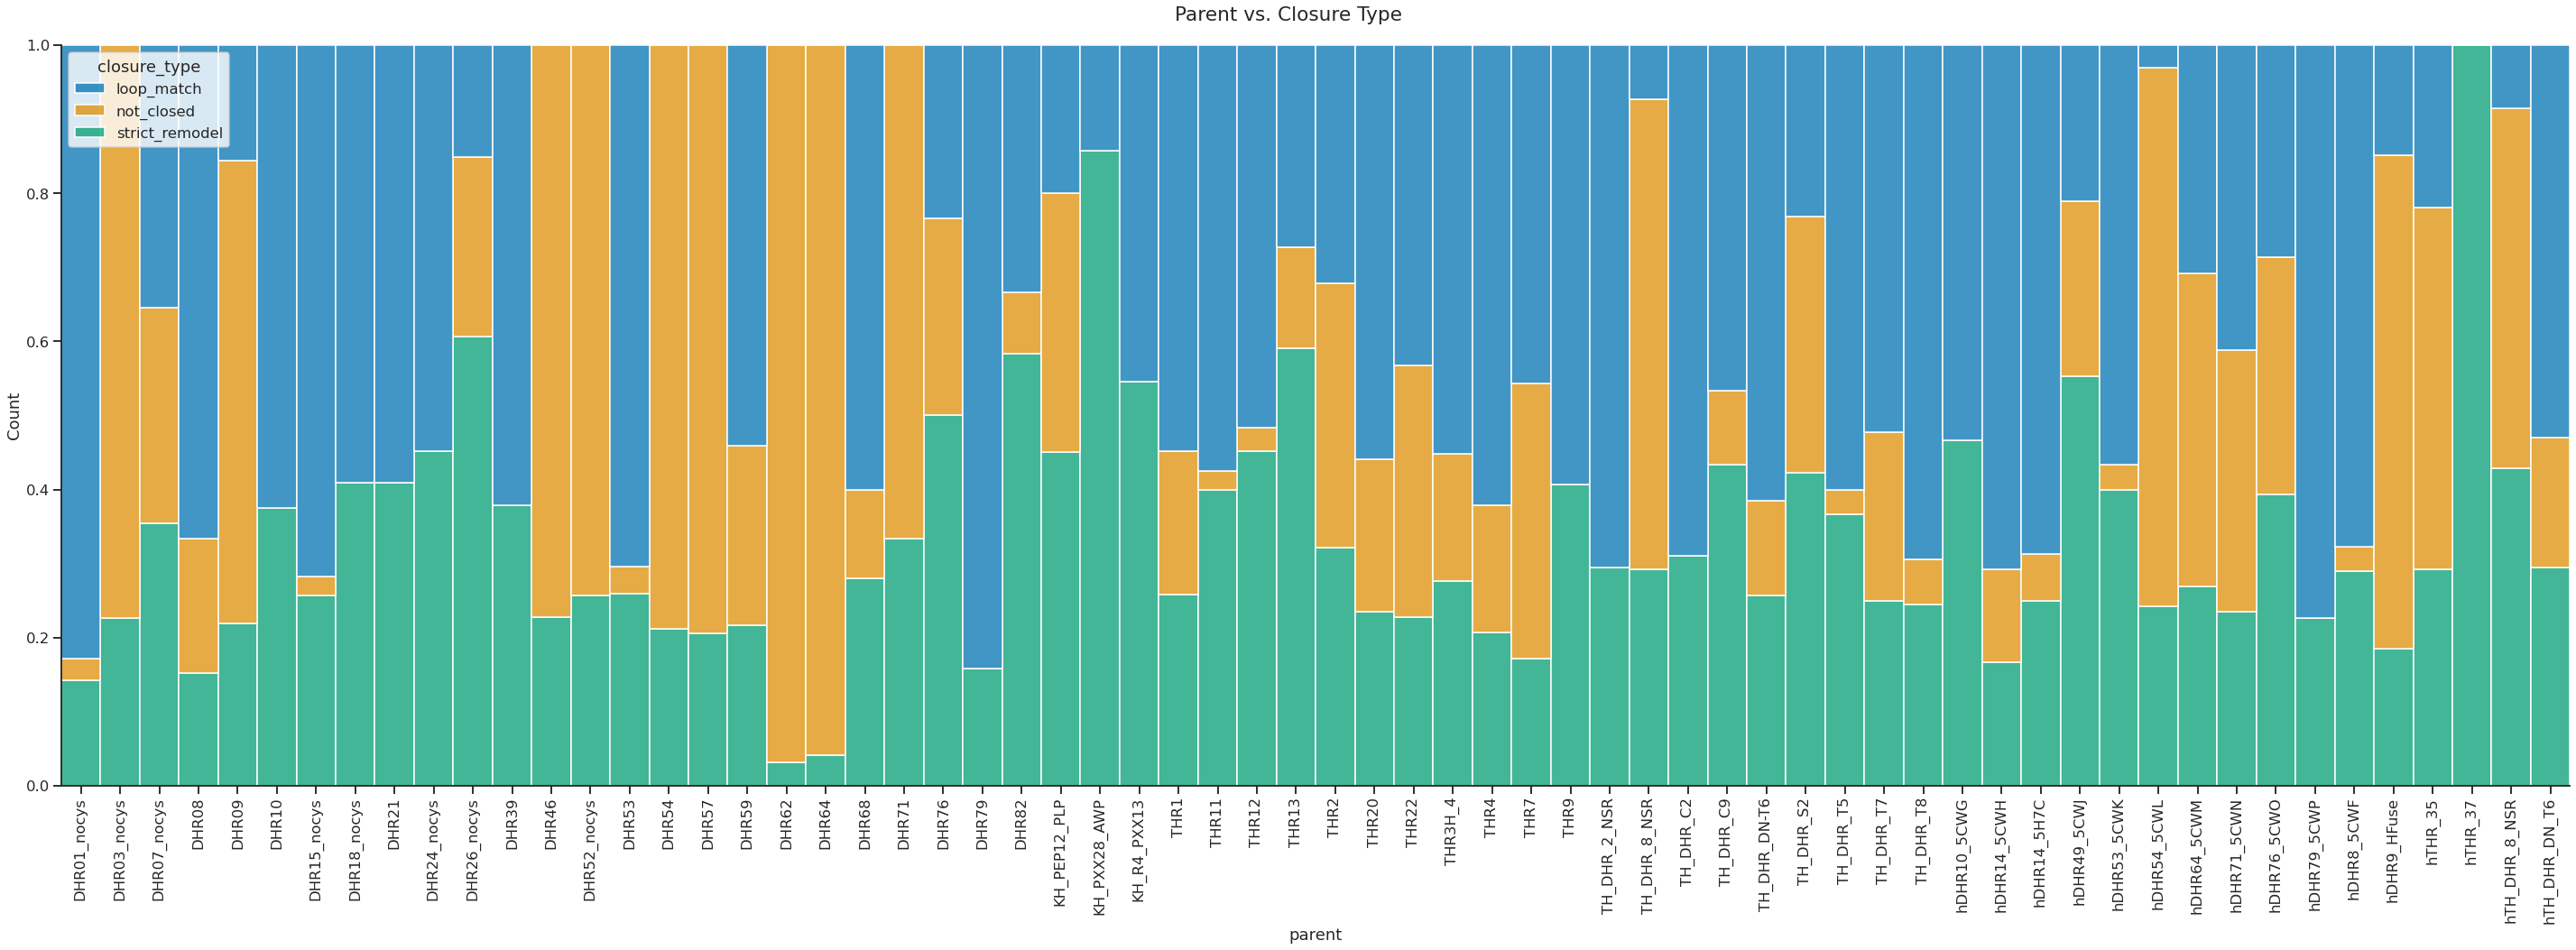

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(40, 15), tight_layout=True)

sns.histplot(
    x="parent",
    data=scores_df.sort_values(["parent"]),
    ax=ax,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)
plt.xticks(rotation=90)
sns.despine()
plt.suptitle("Parent vs. Closure Type")
plt.savefig("figs/03_parent_groupby_closure.png")

### Some DHRs are very hard to close
Remodel improves the success rate by quite a bit
THRs and TH_DHRs varied a lot as well. Seems like helical phase matters a lot

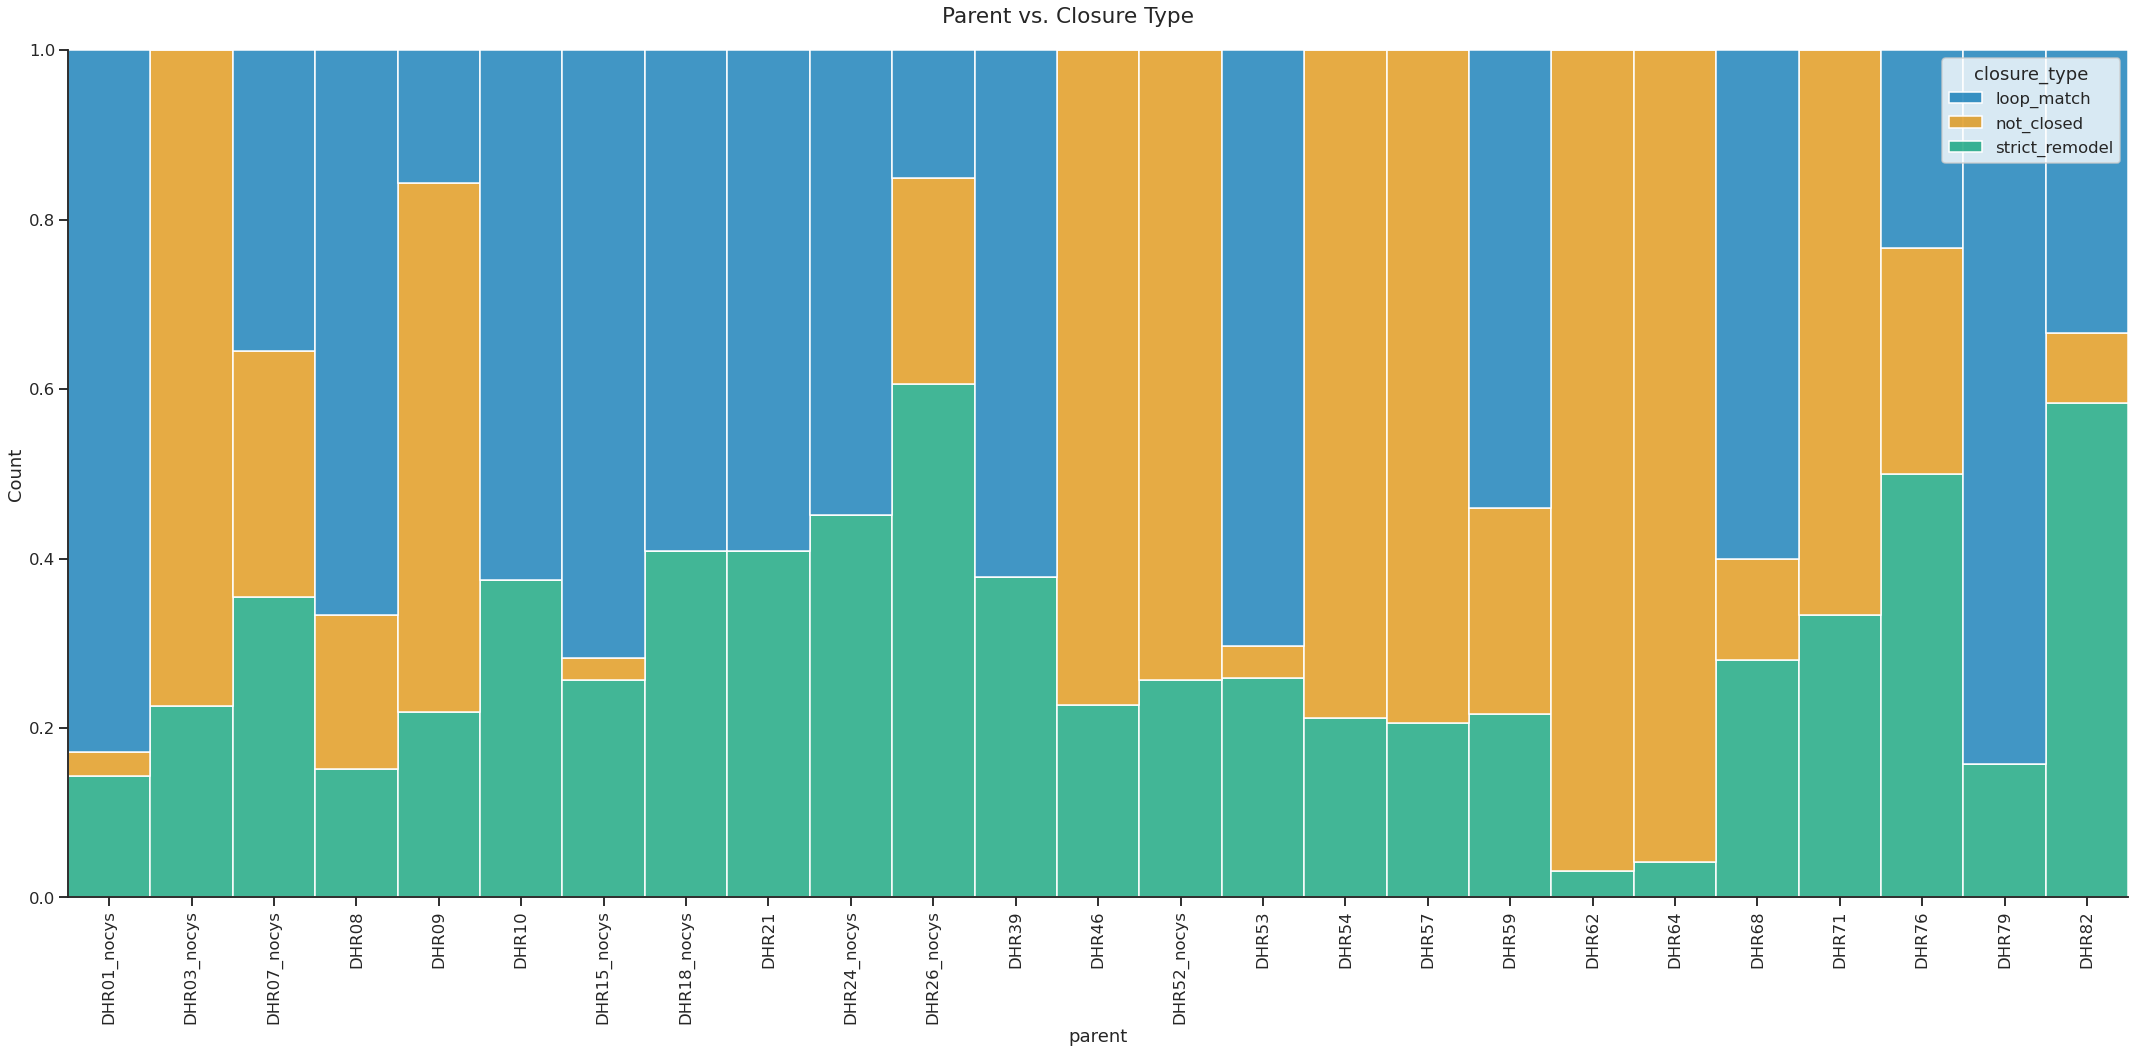

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(30, 15), tight_layout=True)

sns.histplot(
    x="parent",
    data=scores_df[scores_df["scaffold"] == "DHR"].sort_values(["parent"]),
    ax=ax,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)
plt.xticks(rotation=90)
sns.despine()
plt.suptitle("Parent vs. Closure Type")
plt.savefig("figs/03_parent_DHRs_only_groupby_closure.png")

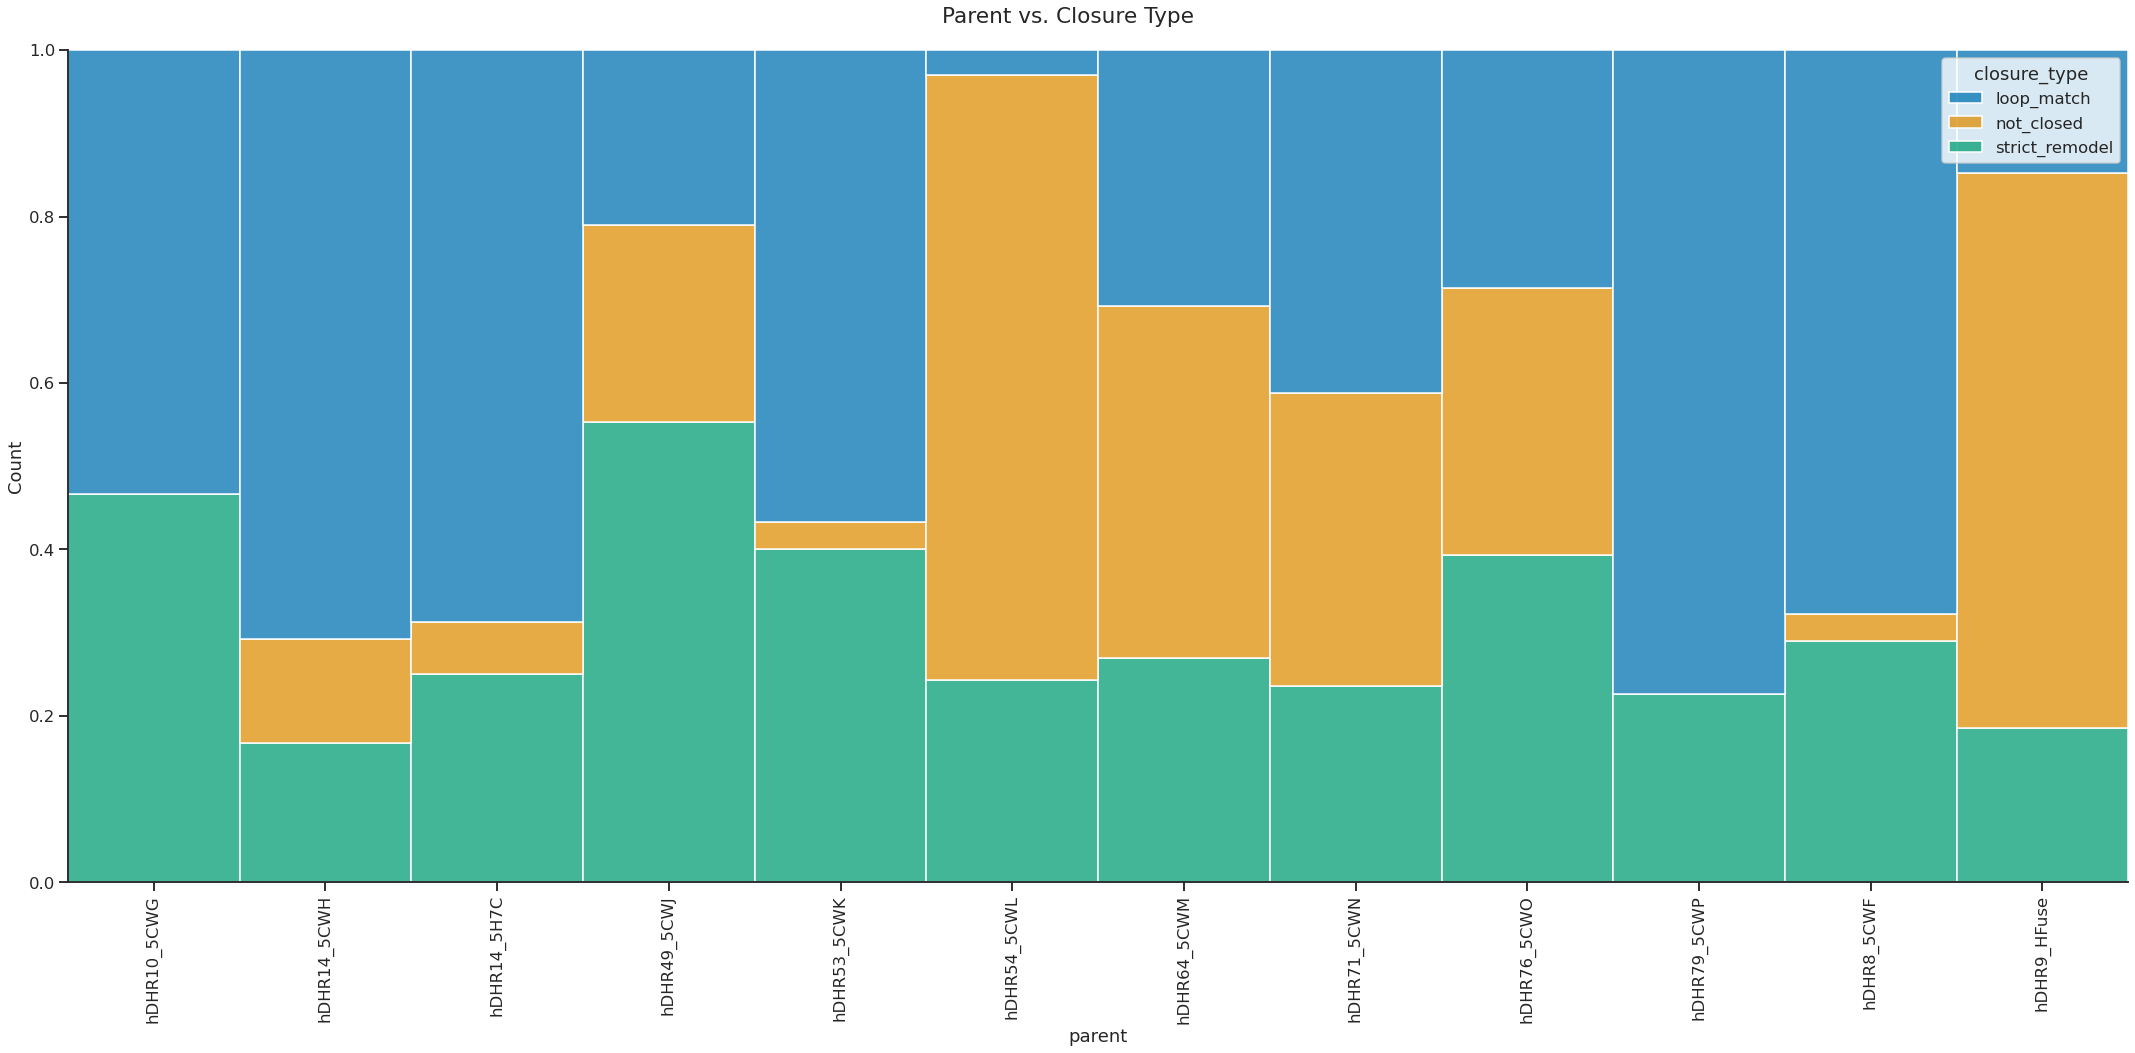

In [22]:
fig, ax = plt.subplots(ncols=1, figsize=(30, 15), tight_layout=True)

sns.histplot(
    x="parent",
    data=scores_df[scores_df["scaffold"] == "hDHR"].sort_values(["parent"]),
    ax=ax,
    hue="closure_type",
    hue_order=hue_order,
    multiple="fill",
)
plt.xticks(rotation=90)
sns.despine()
plt.suptitle("Parent vs. Closure Type")
plt.savefig("figs/03_parent_hDHRs_only_groupby_closure.png")

### Let's get all the ones that were able to be closed
Save a list of the closed designs

In [26]:
closed = scores_df[scores_df.closure_type != "not_closed"]
# the handful of designs that have a helical dssp in the loop need to be taken out too
closed = closed[closed.new_loop_resis != ""]
print(len(closed))
out_path = os.path.join(os.getcwd(), "03_enumerate_loops")
with open(os.path.join(out_path, "closed.list"), "w+") as f:
    for decoy in closed.index:
        print(decoy, file=f)

1516


### Make a function to idealize peptide targets that have disordered regions
Use remodel to force the peptides into semi-idealized helices

In [10]:
from pyrosetta.distributed.packed_pose.core import PackedPose


def remodel_peptide(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Remodel peptides into semi-realistic, semi-idealized helices
    """
    import os
    import pyrosetta
    from pyrosetta.distributed.packed_pose.core import PackedPose
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    def helix_bp(packed_pose_in: PackedPose) -> str:
        import binascii, os

        # name blueprint a random 32 long hex string
        filename = str(binascii.b2a_hex(os.urandom(16)).decode("utf-8")) + ".bp"
        # write a temporary blueprint file
        with open(filename, "w+") as f:
            end1 = packed_pose_in.pose.chain_end(1)
            for i in range(1, end1 + 1):
                print(
                    str(i),
                    packed_pose_in.pose.residue(i).name1(),
                    " HA ",  # we want to force the peptides into a semi realistic helix
                    "R",
                    file=f,
                )
        return filename

    bp = helix_bp(packed_pose_in)
    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
            <ScoreFunction name="sfxn1" weights="fldsgn_cen">
                <Reweight scoretype="hbond_sr_bb" weight="1.0" />
                <Reweight scoretype="hbond_lr_bb" weight="1.0" />
                <Reweight scoretype="atom_pair_constraint" weight="1.0" />
                <Reweight scoretype="angle_constraint" weight="1.0" />
                <Reweight scoretype="dihedral_constraint" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>          
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <RestrictToRepacking name="rtrp" />
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <BluePrintBDR name="bdr" 
            blueprint="{bp}" 
            use_abego_bias="0" 
            use_sequence_bias="1" 
            rmdl_attempts="20"
            scorefxn="sfxn1"/>
            <SwitchResidueTypeSetMover name="fa" set="fa_standard" />
            <PackRotamersMover name="repack" scorefxn="sfxn" task_operations="rtrp" />
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <PROTOCOLS>
            <Add mover_name="bdr"/>
            <Add mover_name="fa"/>
            <Add mover_name="repack"/>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(
        bp=bp
    )
    strict_remodel = SingleoutputRosettaScriptsTask(xml)
    maybe_remodeled_ppose = strict_remodel(packed_pose_in.pose.clone())
    os.remove(bp)  # cleanup tree
    return maybe_remodeled_ppose

### Run the function on the targets that are partially disordered
`glucagon, gip, glp, neuropeptideY`

In [11]:
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

selected = []
targets = glob(os.path.join(os.getcwd(), "00_inputs/targets/raw/*.pdb"))
pyrosetta.distributed.init(
    "-corrections::beta_nov16 true \
    -out:level 300 \
    -holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc \
    -indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5"
)

packed_poses = {}
for i, pdb in enumerate(tqdm(targets)):
    ppose = io.pose_from_file(pdb)
    remodel = remodel_peptide(ppose)
    if remodel is not None:
        packed_poses[pdb] = remodel

  0%|          | 0/4 [00:00<?, ?it/s]

basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
core.util.switchresiduetypeset: {0} [ WARNING ] When switching to a fa_standard ResidueTypeSet:  Pose already contains fa_standard ResidueTypes.


 25%|██▌       | 1/4 [00:42<02:08, 42.78s/it]

core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 3 atoms at position 1 in file /mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/00_inputs/targets/raw/neuropeptideY.pdb. Best match rsd_type:  TYR:NtermProteinFull
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue TYR:CtermProteinFull 36
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
core.util.switchresiduetypeset: {0} [ WARNING ] When switching to a fa_standard ResidueTypeSet:  Pose already contains fa_standard ResidueTypes.


 50%|█████     | 2/4 [01:34<01:35, 47.89s/it]

core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 1 atoms at position 1 in file /mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/00_inputs/targets/raw/gip.pdb. Best match rsd_type:  TYR:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 1 atoms at position 3 in file /mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/00_inputs/targets/raw/gip.pdb. Best match rsd_type:  GLU
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 1 atoms at position 9 in file /mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/00_inputs/targets/raw/gip.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 1 atoms at position 15 in file /mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/00_inputs/targets/raw/gip.pdb. Best match rsd_type:  ASP
core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 1 atoms at position 18 in file /mnt/home/pleung/proje

 75%|███████▌  | 3/4 [02:33<00:53, 53.10s/it]

core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue GLY:CtermProteinFull 26
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
basic.thread_manager.RosettaThreadManager: {0} [ WARNING ] A work vector of size zero was passed to the RosettaThreadManager!  Duly returning without doing anything.
core.util.switchresiduetypeset: {0} [ WARNING ] When switching to a fa_standard ResidueTypeSet:  Pose already contains fa_standard ResidueTypes.


100%|██████████| 4/4 [03:13<00:00, 48.29s/it]


### Make sure the protocol did an ok job using a built in viewer
Can use the following rc: `view.add(viewer.setHydrogenBonds()); view.add(viewer.setDisulfides(radius=0.25))`

In [13]:
import pyrosetta.distributed.viewer as viewer


view = viewer.init(list(packed_poses.values()), window_size=(800, 600))
view.add(viewer.setStyle())
view.add(viewer.setStyle(colorscheme="whiteCarbon", radius=0.05))
view.add(viewer.setHydrogens(polar_only=True))

view()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Decoys', max=3), Output()), _do…

<function pyrosetta.distributed.viewer.core.Viewer.show.<locals>.view(i=0)>

### Write the remodeled targets to disk

In [15]:
for key, value in packed_poses.items():
    value.pose.dump_pdb(key.replace("raw", "0"))

In [16]:
min_length = min([len(ppose.pose.residues) for ppose in packed_poses.values()])
min_length

26

### Make a function to thread the remodeled targets onto the docked helices, replacing the docked helices with a docked target
Try the `MergePDB` mover

In [85]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init


@requires_init
def replace_with_target(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Replace chB with a supplied target helix
    """
    import bz2
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        MultioutputRosettaScriptsTask,
    )

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_pose_in = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        raise RuntimeError("Need to supply an input")

    target_path = kwargs["target"]
    termini = kwargs["termini"]

    true_parent_length = int(packed_pose_in.pose.chain_end(1))
    total_length = int(scores["total_length"])  # len(packed_pose_in.pose.residues)
    chB_length = int(total_length - true_parent_length)

    target_name = target_path.split("/")[-1].replace(".pdb", "", 1)
    target_ppose = io.pose_from_file(target_path)
    target_length = len(target_ppose.pose.residues)
    
    fjell
    

#     overlap = target_length - 7

#     xml = """
#     <ROSETTASCRIPTS>
#         <SCOREFXNS>
#             <ScoreFunction name="sfxn" weights="beta_nov16" /> 
#         </SCOREFXNS>
#         <RESIDUE_SELECTORS>          
#         </RESIDUE_SELECTORS>
#         <TASKOPERATIONS>
#             <RestrictToRepacking name="rtrp" />
#         </TASKOPERATIONS>
#         <SIMPLE_METRICS>
#         </SIMPLE_METRICS>
#         <MOVERS>
#             <MergePDB name="thread"
#                 attach_pdb="{xml_pose}" 
#                 attachment_termini="{termini}"
#                 chain="B" overlap_length="{overlap}"
#                 overlap_rmsd="1.5"
#                 overlap_scan_range_cmdLine_pose="{cmd_scan}"
#                 overlap_scan_range_xml_pose="{xml_scan}"
#                 design_range="9"
#                 packing_range="8" 
#                 duplicate_rmsd_pose_threshold="1.0"
#                 init_overlap_sequence="xml_pose"
#                 scorefxn="sfxn" output_only_first="false"
#                 output_overlap_positions="true"
#                 do_design="false" do_minimize="false" 
#                 task_operations="rtrp" />
#         </MOVERS>
#         <FILTERS>
#         </FILTERS>
#         <PROTOCOLS>
#             <Add mover_name="thread"/>
#         </PROTOCOLS>
#     </ROSETTASCRIPTS>
#     """.format(
#         xml_pose=target_path,
#         termini=termini,
#         overlap=overlap,
#         cmd_scan=chB_length - overlap - 1,
#         xml_scan=overlap + 1,  # target_length - 5,  # - overlap,
#         #         target_length=target_length,
#     )
#     print(xml)  # TODO
#     threader = MultioutputRosettaScriptsTask(xml)  # returns a ppose generator
#     threaded_pposes = threader(packed_pose_in.pose.clone())

    poses = []
    for ppose in threaded_pposes:
        pose = io.to_pose(ppose)
#         pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "chB_length", chB_length)
        pyrosetta.rosetta.core.pose.setPoseExtraScore(
            pose, "target_length", target_length
        )
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "target_name", target_name)
        for key, value in scores.items():
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, str(value))
        pyrosetta.rosetta.core.pose.setPoseExtraScore(
            pose, "parent_length", true_parent_length
        )
        poses.append(pose)

    final_pposes = io.to_packed(poses)
    return final_pposes

### Unused

In [86]:
from pyrosetta.distributed import cluster


selected = []
designs = os.path.join(os.getcwd(), "03_enumerate_loops/closed.list")
with open(designs, "r") as f:
    for file in f:
        selected.append(file.rstrip())

print(selected[1])

pyrosetta.distributed.init(
    "-corrections::beta_nov16 true \
    -out:level 300 \
    -holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc \
    -indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5"
)

# tppose = loop_match(None, **{"-s": selected[0]})
tpposes = replace_with_target(
    None,
    **{
        "-s": selected[1],
        "target": "/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/00_inputs/targets/0/apoe.pdb",
        "termini": "n_term",
    }
)

/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/03_enumerate_loops/decoys/0000/2021.05.28.14.56.04.308744_dcda8d8a047c47ac86f4e297b076e1b8.pdb.bz2
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue VAL:CtermProteinFull 220
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue GLN:CtermProteinFull 17

    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" /> 
        </SCOREFXNS>
        <RESIDUE_SELECTORS>          
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <RestrictToRepacking name="rtrp" />
        </TASKOPERATIONS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <MOVERS>
            <MergePDB name="thread"
                attach_pdb="/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/00_inputs/targets/0/apoe.pdb" 
                attachment_termini="n_term"
                chain="B" overlap_length="10"
                overla

RuntimeError: 

File: /home/benchmark/rosetta/source/src/core/pose/Pose.cc:951
[ ERROR ] UtilityExitException
ERROR: Pose::residue( Size const seqpos ): variable seqpos is out of range!



In [83]:
len(tpposes)

26

In [84]:
for i, ppose in enumerate(tpposes):
    ppose.pose.dump_pdb(f"{i}.pdb")